# Resources and credit:
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html

# Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 17.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=0e86d19806a8240ec0fbf6d61a84af52c3d0ccfe2953aaec492ca64947259303
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 724kB/s 
     |████████████████████████████████| 2.2MB 17.4MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210305-cp37-none-any.whl size=57713 sha256=616048e78531ed230d7980fa0b1b474e192d069689d8a5a7777b503fc8920c97
  Stored in directory: /root/.cache/pip/wheels/2d/fd/99/f2290219c7af129716ba314036e666fcaa7ee6fb55077df167
  Created wheel for iopath: filename=iopath-0.1.4-cp37-none-any.whl size=15571 sha256=f2e36e043f9020835c934a53e277dfb54e1462739beff8ec1b3598fd6d385195
  Stored in directory: /root/.cache/pip/wheels/54/3b/fb/25b60ef5989e3f5fd76fdc575c922e6e59066ddbd1b44756a9
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

# Registration
*Register train, test, test_offshore, test_inshore datasets*

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [ ]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from detectron2.structures import BoxMode
# Register
for d in ["train", "test", "test_offshore", "test_inshore", "train/train_w_val", "train/validation", "train/toy"]:
    DatasetCatalog.register(d, lambda d=d: get_dict(d))
    MetadataCatalog.get(d).set(thing_classes=["ship"])

In [ ]:
# Instances of metadata
train_metadata = MetadataCatalog.get('train')
test_metadata = MetadataCatalog.get('test')
train_w_val_metadata = MetadataCatalog.get('train/train_w_val')
validation_metadata = MetadataCatalog.get('train/validation')
toy_metadata = MetadataCatalog.get('train/toy')
test_offshore = MetadataCatalog.get('test_offshore')
train_offshore = MetadataCatalog.get('train_offshore')

# Copy Paste
*Create copy+paste subroutine to be used in data augmentation*

In [ ]:
import cv2

class copyPaste():
  def __init__(self, annotation):
    self.ann = copy.deepcopy(annotation)

  def load_image(self, image = None):
    self.image = image
    if self.image is None:
      self.image = utils.read_image(self.ann["file_name"],
                                    format="BGR")

  def valid_copy(self, xmin, xmax, ymin, ymax):
    valid = xmin > 0 and xmax < 800 and ymin > 0 and ymax < 800
    bboxs = [i['bbox'] for i in self.ann['annotations']]
    iou = self.calc_iou(bboxs, [xmin, ymin, xmax, ymax])
    valid = valid and np.all(np.isclose(iou, 0))
    return valid 

  def calc_iou(self, bboxes, bbox):
    #https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d
    x11, y11, x12, y12 = np.split(np.array(bboxes), 4, axis=1)
    x21, y21, x22, y22 = np.split(np.array(bbox), 4, axis=0)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

  def parse(self):
    bbox = self.ann['annotations'][self.index]['bbox']
    self.xmin = bbox[0]
    self.xmax = bbox[2]
    self.ymin = bbox[1]
    self.ymax = bbox[3]

  def copyImg(self):
    self.parse()
    self.copy = self.image[self.ymin: self.ymax, 
                 self.xmin:self.xmax, :]
    
  def translate(self):
    xmin = self.xmin + self.xdel
    xmax = self.xmax + self.xdel
    ymin = self.ymin + self.ydel
    ymax = self.ymax + self.ydel
    return (xmin, xmax, ymin, ymax)

  def update_ann(self, xmin, ymin, xmax, ymax):
    new = {'bbox': [xmin, ymin, xmax, ymax],
           'bbox_mode': BoxMode.XYXY_ABS,
           'category_id': 0}
    self.ann['annotations'].append(new)

  def copyPaste(self, index, xdel, ydel):
    self.index = index
    self.copyImg()
    self.xdel = xdel
    self.ydel = ydel
    xmin, xmax, ymin, ymax = self.translate()
    if self.valid_copy(xmin, xmax, ymin, ymax):
      temp = self.image.copy()
      temp[ymin:ymax, xmin:xmax, :] = self.copy
      self.image = temp
      self.update_ann(xmin, ymin, xmax, ymax)

  def getImage(self):
    return self.image
  
  def getAnn(self):
    return self.ann

# Data Augmentation
*Create custom mapper for data augmentation*

In [ ]:
from detectron2.utils.visualizer import Visualizer

def printImage(im, dataset_dict):
  v = Visualizer(im[:, :, ::-1], 
                 scale=0.5)
  out = v.draw_dataset_dict(dataset_dict)
  image = out.get_image()[:, :, ::-1]
  return image

In [ ]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import logging
import copy
from cv2 import hconcat
import torch
# https://gilberttanner.com/blog/detectron-2-object-detection-with-pytorch

def custom_mapper(dataset_dict, copy_paste = True):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # Only for viewing
    preImage = printImage(image, dataset_dict) # only for viewing

    # Copy paste 
    if copy_paste:
      PI = 8
      SIGMA = 300
      preAnns = len(dataset_dict['annotations'])
      ex = copyPaste(dataset_dict)
      ex.load_image(image)
      for i in range(preAnns):
        pastes = random.randint(1,PI)
        for j in range(pastes):
          sample = np.random.multivariate_normal([0,0], SIGMA*np.diag((2,2))).astype(int)
          xdel = sample[0]
          ydel = sample[1]
          ex.copyPaste(i, xdel, ydel)

      dataset_dict = ex.getAnn()
      postAnns = len(dataset_dict['annotations'])
      image = ex.getImage()
      #logger = logging.getLogger("detectron2")
      #logger.info(f"Annotations before {preAnns}, Annotations after {postAnns}")

    transform_list = [
        #T.Resize((800,800)),
        #T.RandomBrightness(0.8, 1.8),
        #T.RandomContrast(0.6, 1.3),
        #T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        #T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]

    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    # only for viewing
    dataset_dict['annotations'] = annos
    postImage = printImage(image, dataset_dict)
    dataset_dict.pop('annotations')
    cv2_imshow(cv2.hconcat([preImage, postImage]))

    return dataset_dict

# Visualize Augmentation

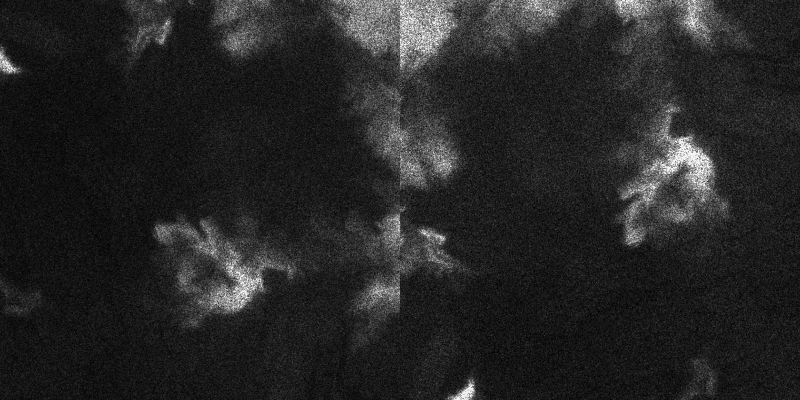

In [ ]:
from detectron2.data import detection_utils as utils
train = get_dict('train')
train_sample = [i for i in train if i['file_name']=='/content/drive/MyDrive/SSDD/datasets/train/05_10_22.jpg'][0]
train_sample = train[random.randint(0, len(train))]
test = custom_mapper(train_sample)

# Custom Evaluator

In [ ]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from collections import OrderedDict
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import itertools
import contextlib
import torch
import copy
import os
import io

In [ ]:
def average_precision(correct, ground_truth): 
  # correct contains True Positives (TP) and False Positives (FP)
  # ground_truth is the number of positive examples (TP + FN = GT)

  # precision = TP / (TP + FP)
  # recall = TP / (TP + FN) = TP / GT
  TP = 0
  FP = 0
  GT = ground_truth
  precision = []
  recall = []

  for i, c in enumerate(correct):
    if c:
      TP += 1
    else:
      FP += 1
    precision.append(TP / (TP + FP))
    if GT == 0:
      recall.append(0.0)
    else:
      recall.append(TP / GT)

  # Interpolate precision (replace each precision value with the maximum
  # precision value to the right of that recall level)
  max = 0
  precision_interp = []

  for i, c in enumerate(reversed(precision)):
    if c > max:
      max = c
      precision_interp.append(c)
    else:
      precision_interp.append(max)
  
  precision_interp = list(reversed(precision_interp))


  # Calculate AP (Average Precision)
  AP = 0
  for i, c in enumerate(recall):
    if i == 0:
      continue
    AP += (recall[i] - recall[i-1]) * precision_interp[i]
  
  return recall, precision_interp, AP


# Test Case
test = [True, True, False, False, False, True, True, False, False, True]
recall, precision, AP = average_precision(test, 5)
assert AP == 0.5285714285714286
assert recall == [0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 0.8, 1.0]
assert precision == [1.0, 
                    1.0, 
                    0.6666666666666666,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5714285714285714,
                    0.5,
                    0.5,
                    0.5]

In [ ]:
class CustomEvaluator(DatasetEvaluator):
  def __init__(
        self,
        dataset_name,
        output_dir
    ):
      """
      Args:
          dataset_name (str): name of the dataset to be evaluated.
              It must have either the following corresponding metadata:
                "json_file": the path to the COCO format annotation
                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
                output_dir (str): an output directory to dump all
                results predicted on the dataset. 
                  
              The dump contains two files:
              1. "instances_predictions.pth" (dataset_name + "_predictions.pth")
                  a file that can be loaded with `torch.load` and
                  contains all the results in the format they are produced by the model.
              2. "coco_instances_results.json" a json file in COCO's result format.
      """
      self._cpu_device = torch.device("cpu")
      self.dataset_name = dataset_name
      self._metadata = MetadataCatalog.get(dataset_name)
      self._output_dir = output_dir
      if not hasattr(self._metadata, "json_file"):
        cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
        self._metadata.json_file = cache_path
        convert_to_coco_json(dataset_name, cache_path)

      json_file = PathManager.get_local_path(self._metadata.json_file)
      with contextlib.redirect_stdout(io.StringIO()):
          self._coco_api = COCO(json_file)

  def reset(self):
    """
    Preparation for a new round of evaluation.
    """
    self._predictions = []

  def process(self, inputs, outputs):
    """
    Process the pair of inputs and outputs.
    """
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device) 
      if len(prediction) > 1:
          self._predictions.append(prediction)
    if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir,
                                     self.dataset_name + "_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(self._predictions, f)

  def evaluate(self):
    """
    Evaluate/summarize the performance, after processing all input/output pairs.
    """
    iou_threshold = 0.5 # pg.23 of Zhang et al. 
    num_instances = 0
    num_pos = 0 # must be equal to GT
    gt_overlaps = []
    scores = []
    correct = []
    bad_images = []

    if len(self._predictions) == 0:
      return {}, {}, {}

    # Loop overall all instances in one image
    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)

      # Get scores of each instance, sort
      inds = predictions.get_fields()['scores'].sort(descending=True)[1]
      in_scores = predictions.get_fields()['scores']
      in_scores = in_scores[inds]
      
      # Get bbox of each instance, sort by score
      in_boxes = predictions.get_fields()['pred_boxes']
      in_boxes = in_boxes[inds]

      assert len(in_boxes) == len(in_scores) == len(predictions)

      # Retrieve corresponding ground truth boxes/labels
      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno = self._coco_api.loadAnns(ann_ids)
      gt_boxes = [
          BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
          for obj in anno
          if obj["iscrowd"] == 0
      ]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

      num_pos += len(gt_boxes)

      # Compute IOU for each instance-ground truth pair
      overlaps = pairwise_iou(in_boxes, gt_boxes)

      _gt_overlaps = torch.zeros(len(gt_boxes)) # stores best pred/gt iou
      _scores = torch.zeros(len(in_scores)) # stores iou for each score
      
      # Ensure 1-1 mapping between prediction and gt boxes
      for j in range(min(len(predictions), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)

          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0

          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]

          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]
          assert _gt_overlaps[j] == gt_ovr

          # record this iou coverage for score
          _scores[box_ind] =  overlaps[box_ind, gt_ind]
          assert _scores[box_ind] == gt_ovr

          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1

      # update collectors
      _correct = (_scores >= iou_threshold).tolist()

      if _correct and sum(np.invert(_correct)) > 0:
        bad_images.append(prediction_dict)
      assert len(_correct) == len(_scores) == len(predictions)
      scores.append(in_scores)
      correct.append(_correct)
      gt_overlaps.append(_gt_overlaps)

    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps)
         else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps, descending = True)

    scores = (
        torch.cat(scores, dim=0) if len(scores)
         else torch.zeros(0, dtype=torch.float32)
    )
    scores, ind = torch.sort(scores, descending = True)

    # stores TP/FP for each proposal box in all images 
    # (in descending order of scores)
    correct = list(itertools.chain.from_iterable(correct))
    assert len(scores) == len(correct)
    correct = [correct[i] for i in ind.tolist()]

    # The following metrics are computed at iou_threshold
    GT = len(self._coco_api.getAnnIds())
    assert GT == num_pos

    TP = np.sum(np.array(correct))
    FP = len(correct) - TP
    assert (TP + FP) == num_instances
    FN = GT - TP

    Pd = TP / GT          # Detection probability
    Pf = FP / (TP + FP)   # false alarm
    Pm = FN / GT          # missed detection

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2*(precision * recall) / (precision + recall)
    recalls, precisions, mAP = average_precision(correct, GT)

    plot =  {"recalls": recalls, "precisions": precisions}
    hist = {"gt_overlap" : gt_overlaps, "scores": scores}
    self._results = {
        "TP": TP,
        "FP": FP,
        "GT": GT,
        "FN": FN,
        "Pd": Pd,
        "Pf": Pf,
        "Pm": Pm,
        "recall": recall,
        "precision": precision,
        "mAP": mAP,
        "F1": F1
    }


    print(self._results)    
    # Alternative return
    # return copy.deepcopy(self._results), plot, hist, bad_images

    return copy.deepcopy(self._results)

# Validation Loss

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.utils.comm import get_world_size
import detectron2.utils.comm as comm
import logging
import torch
import time
import datetime
# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b
# https://github.com/facebookresearch/detectron2/blob/master/detectron2/evaluation/evaluator.py
# https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/train_loop.py
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/utils/events.html
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/utils/logger.html


# Computes loss on the validation set during training
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # based on inference_on_dataset() from evaluator.py
        num_devices = get_world_size()

#        logger = logging.getLogger(__name__)
        logger = logging.getLogger("detectron2")
        logger.info("Start validation_loss computation on {} images".format(len(self._data_loader)))

        total = len(self._data_loader)  # inference data loader must have a fixed length
        num_warmup = min(5, total - 1)
        start_time = time.perf_counter()
        total_compute_time = 0

        losses = []

        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            
            start_compute_time = time.perf_counter()

            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            total_compute_time += time.perf_counter() - start_compute_time

            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n = 60, # log no more than once per n seconds
                )
            
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        

        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss) # The loss on the validation set is added to TensorBoard plots

        logger.info(
            "  eta: {}  iter: {}  validation_loss: {:.4g}".format(
                str(eta), self.trainer.iter, mean_loss
            ) # eta is not computed
        )

        # Measure the time only for this worker (before the synchronization barrier)
        total_time = time.perf_counter() - start_time
        total_time_str = str(datetime.timedelta(seconds=total_time))
        # Note this format is parsed by grep
        logger.info(
            "Total validation_loss computation time: {} ({:.6f} s / img per device, on {} devices)".format(
                total_time_str, total_time / (total - num_warmup), num_devices
            )
        )

        total_compute_time_str = str(datetime.timedelta(seconds=int(total_compute_time)))
        logger.info(
            "Total validation_loss computation pure compute time: {} ({:.6f} s / img per device, on {} devices)".format(
                total_compute_time_str, total_compute_time / (total - num_warmup), num_devices
            )
        )

        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # loss calculated on train_loop.py 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }

        total_losses_reduced = sum(loss for loss in metrics_dict.values())

        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = (next_iter == self.trainer.max_iter)

        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        
        self.trainer.storage.put_scalars(timetest=12)

# Custom Trainer

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.evaluation import COCOEvaluator  # To use the COCO validation evaluation during training. Otherwise no validation eval occurs.
# model zoo - https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection
# detectron2.config - https://detectron2.readthedocs.io/en/latest/modules/config.html
# Custom training https://github.com/facebookresearch/detectron2/blob/master/tools/train_net.py
# Custom training https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py
# DefaultTrainer https://detectron2.readthedocs.io/en/latest/_modules/detectron2/engine/defaults.html
# DefaultTrainer https://github.com/facebookresearch/detectron2/blob/master/detectron2/engine/defaults.py
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
# https://gilberttanner.com/blog/detectron-2-object-detection-with-pytorch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Custom trainer
class CustomTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        output_folder = os.path.join(cfg.OUTPUT_DIR, "Validation_Eval")
        os.makedirs(output_folder, exist_ok=True)
        return CustomEvaluator(dataset_name, output_dir=output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, 
          LossEvalHook(
              cfg.TEST.EVAL_PERIOD,
              self.model,
              build_detection_test_loader(
                  self.cfg,
                  self.cfg.DATASETS.TEST[0],
                  DatasetMapper(self.cfg, True) 
              )
            )
          )
        return hooks

    @classmethod
    def test(cls, cfg, model, evaluators=None):
        """
        Args:
            cfg (CfgNode):
            model (nn.Module):
            evaluators (list[DatasetEvaluator] or None): if None, will call
                :meth:`build_evaluator`. Otherwise, must have the same length as
                ``cfg.DATASETS.TEST``.

        Returns:
            dict: a dict of result metrics
        """
        logger = logging.getLogger(__name__)
        if isinstance(evaluators, DatasetEvaluator):
            evaluators = [evaluators]
        if evaluators is not None:
            assert len(cfg.DATASETS.TEST) == len(evaluators), "{} != {}".format(
                len(cfg.DATASETS.TEST), len(evaluators)
            )

        results = OrderedDict()
        for idx, dataset_name in enumerate(cfg.DATASETS.TEST):
            data_loader = cls.build_test_loader(cfg, dataset_name)
            evaluator = cls.build_evaluator(cfg, dataset_name)
            results_i = inference_on_dataset(model, data_loader, evaluator)
            results[dataset_name] = results_i
            
        if len(results) == 1:
            results = list(results.values())[0]
        return results
      
    # For data augmentation  
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

    '''
    #https://www.programcreek.com/python/?code=zudi-lin%2Fpytorch_connectomics%2Fpytorch_connectomics-master%2Fconnectomics%2Fengine%2Fsolver%2Fbuild.py
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        return ReduceLROnPlateau(
            optimizer,
            mode='min', factor=cfg.SOLVER.GAMMA, patience=500, 
            threshold=0.001, threshold_mode='rel', cooldown=0, 
            min_lr=1e-06, eps=1e-08, verbose = True
        )
    '''

# Training
*Train the Detectron2 model*

**Change Runtime to GPU before running**

In [ ]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_X_101_32x8d_FPN_3x_3_3_2021_train_val_copy_paste"

/content/drive/MyDrive/SSDD


In [ ]:
from detectron2.engine import DefaultTrainer
# model zoo - https://github.com/facebookresearch/detectron2/tree/master/configs/COCO-Detection
# config references - https://detectron2.readthedocs.io/en/latest/modules/config.html#config-references

'''
Model Specifications
'''

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.OUTPUT_DIR = model_name
cfg.MODEL.WEIGHTS =  os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # default is 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ship)

'''
Data Specifications
'''
cfg.DATASETS.TRAIN = ("train/train_w_val",)
cfg.DATASETS.TEST = ("train/validation",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # allows training examples without annotations
cfg.TEST.EVAL_PERIOD = 1000 # e.g. 2 images / iteration * 50 iterations = 1 batch
cfg.TEST.DETECTIONS_PER_IMAGE = 100
cfg.INPUT.RANDOM_FLIP = "none"

'''
Solver Specifications
  taken from Section 5.1 of Zhang et al.
'''
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR" # https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.MultiStepLR
cfg.SOLVER.STEPS = (30000,)
cfg.SOLVER.IMS_PER_BATCH = 2 # Authors used 1 - doubling for speed
cfg.SOLVER.MAX_ITER = 60000   # e.g. 6000 images per epoch * 12 epochs / 2 batch / image = 36,000 iterations
cfg.SOLVER.BASE_LR = 0.001  # Authors used 0.01 - diverges with Detectron2
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 # Save a checkpoint after every this number of iterations

# Run Model

In [ ]:
cfg.OUTPUT_DIR

'./ModelOutput/faster_rcnn_X_101_32x8d_FPN_3x_3_3_2021_train_val_copy_paste'

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg) 
trainer.resume_or_load(resume=True) # Train from scratch
trainer.train()

[03/05 07:34:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# TensorBoard

In [ ]:
# Look at training curves in tensorboard:
%cd ModelOutput/
%load_ext tensorboard
%tensorboard --logdir faster_rcnn_X_101_32x8d_FPN_3x_3_3_2021_train_val_copy_paste
%cd ..

# Plot Training

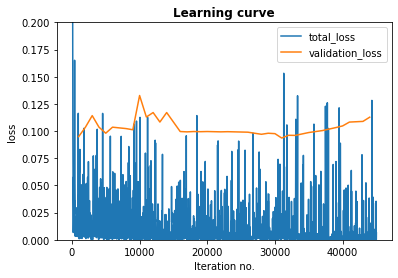

In [ ]:
import json
import matplotlib.pyplot as plt

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

# list of dicts
model_metrics = load_json_arr(model_name + '/metrics.json')

plt.plot(
    [x['iteration'] for x in model_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in model_metrics if 'total_loss' in x]
)

plt.plot(
    [x['iteration'] for x in model_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in model_metrics if 'validation_loss' in x]
)

plt.xlabel('Iteration no.')
plt.ylabel('loss')
plt.title('Learning curve', fontweight ="bold")
plt.legend(['total_loss', 'validation_loss'], loc='upper right')
plt.ylim(0, .2)
plt.show()